In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model

#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from textblob import TextBlob 
from wordcloud import WordCloud 

import warnings
warnings.filterwarnings('ignore')

Using Theano backend.


In [2]:
df_2 = web.DataReader('MRNA','yahoo','2019','2021')
df_2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,15.450000,14.510000,14.930000,15.330000,2318100,15.330000
2019-01-03,16.080000,15.200000,15.490000,15.500000,1588900,15.500000
2019-01-04,17.500000,15.894000,16.000000,16.959999,1651800,16.959999
2019-01-07,17.940001,16.180000,17.540001,16.270000,1585400,16.270000
2019-01-08,17.468000,16.049999,17.350000,16.950001,1892700,16.950001
...,...,...,...,...,...,...
2020-12-24,129.699997,122.720001,125.940002,123.389999,12720600,123.389999
2020-12-28,122.879997,111.050003,120.040001,111.400002,31088200,111.400002
2020-12-29,116.250000,106.879997,107.795998,114.389999,23718800,114.389999


In [4]:
df_data = pd.DataFrame(df_2['Adj Close'])

In [5]:
#training_data_len, dataset, scaler, scaled_data = preprocessing(df_data['Adj Close'], percentage=.8)
n = int(len(df_data) * 0.8)
train = df_data[:n]
test = df_data[n:]

In [6]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [7]:
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    #print('\n')
    #display(autoarima_model.summary())
    
    return autoarima_model


In [8]:
stepwise_fit = arima_model(train['Adj Close'])

In [9]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  404
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -876.165
Date:                              Sun, 31 Jan 2021   AIC                           1760.330
Time:                                      21:51:10   BIC                           1776.215
Sample:                                           0   HQIC                          1766.626
                                              - 404                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0194      0.027      0.732      0.464      -0.033       0.071
ar.L1          0.9886      0.008    129.341      0.000       0.974       1.004
ma.S.L12      -0.9113      0.028    -32.919      0.000      -0.966      -0.857
sigma2         4.8379      0.139     34.758      0.000       4.565       5.111
===================================================================================
Ljung-Box (Q):                       60.72   Jarque-Bera (JB):              2195.46
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              15.53   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
arima_list = [['zipcode', 'pdq','seasonal_pdq','aic']] 
for col in df_data.columns:
  zip_test_2 = arima_model(df_data[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

,zipcode,pdq,seasonal_pdq,aic
0,Adj Close,"(1, 0, 0)","(0, 1, 1, 12)",2571.528735


In [11]:
import statsmodels.api as sm

In [12]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

In [13]:
train['Adj Close'][[0,-1]]

Date
2019-01-02    15.330000
2020-08-07    74.099998
Name: Adj Close, dtype: float64

In [14]:
test['Adj Close'][[0,-1]]

Date
2020-08-10     72.010002
2020-12-31    104.470001
Name: Adj Close, dtype: float64

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                  505
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1251.497
Date:                              Sun, 31 Jan 2021   AIC                           2508.995
Time:                                      21:53:03   BIC                           2521.516
Sample:                                           0   HQIC                          2513.917
                                              - 505                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9956      0.003    341.321      0.000       0.990       1.001
ma.S.L12      -0.9297      0.020    -47.594      0.000      -0.968      -0.891
sigma2        10.4061      0.255     40.764      0.000       9.906      10.906
===================================================================================
Ljung-Box (Q):                       89.16   Jarque-Bera (JB):              3617.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              38.81   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


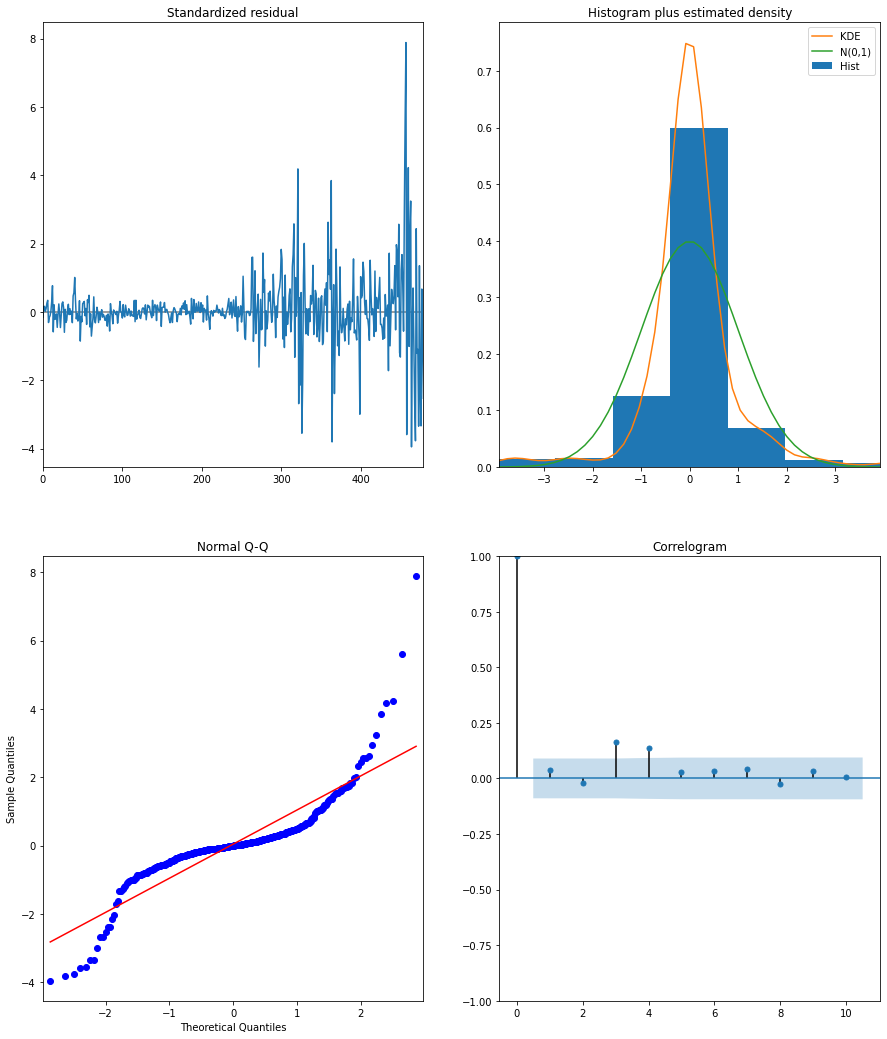

In [15]:
current_zip = 'Adj Close'
zip_params= output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(df_data[current_zip],order=zip_params.pdq.values[0], seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=False)
pred_conf = pred.conf_int()

In [16]:
from matplotlib.pylab import rcParams

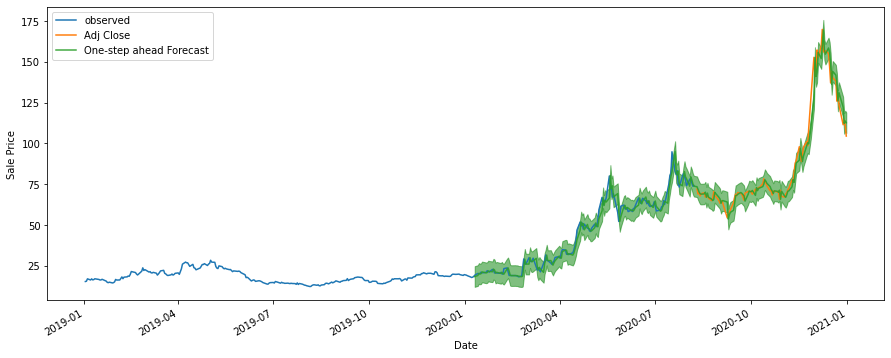

In [17]:

rcParams['figure.figsize'] = 15, 6
#plt.figure(figsize=(12,5))
# Plot observed values
ax = train['Adj Close']['2019':].plot(label='observed')#
test['Adj Close']['2019':].plot()#label='Test'
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()


In [18]:
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 =test['Adj Close']['1996':]

# Compute the root mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 30.77
The Root Mean Squared Error of our forecasts is 5.55


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                  505
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1251.497
Date:                              Sun, 31 Jan 2021   AIC                           2508.995
Time:                                      21:53:06   BIC                           2521.516
Sample:                                           0   HQIC                          2513.917
                                              - 505                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9956      0.003    341.321      0.000       0.990       1.001
ma.S.L12      -0.9297      0.020    -47.594      0.000      -0.968      -0.891
sigma2        10.4061      0.255     40.764      0.000       9.906      10.906
===================================================================================
Ljung-Box (Q):                       89.16   Jarque-Bera (JB):              3617.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              38.81   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


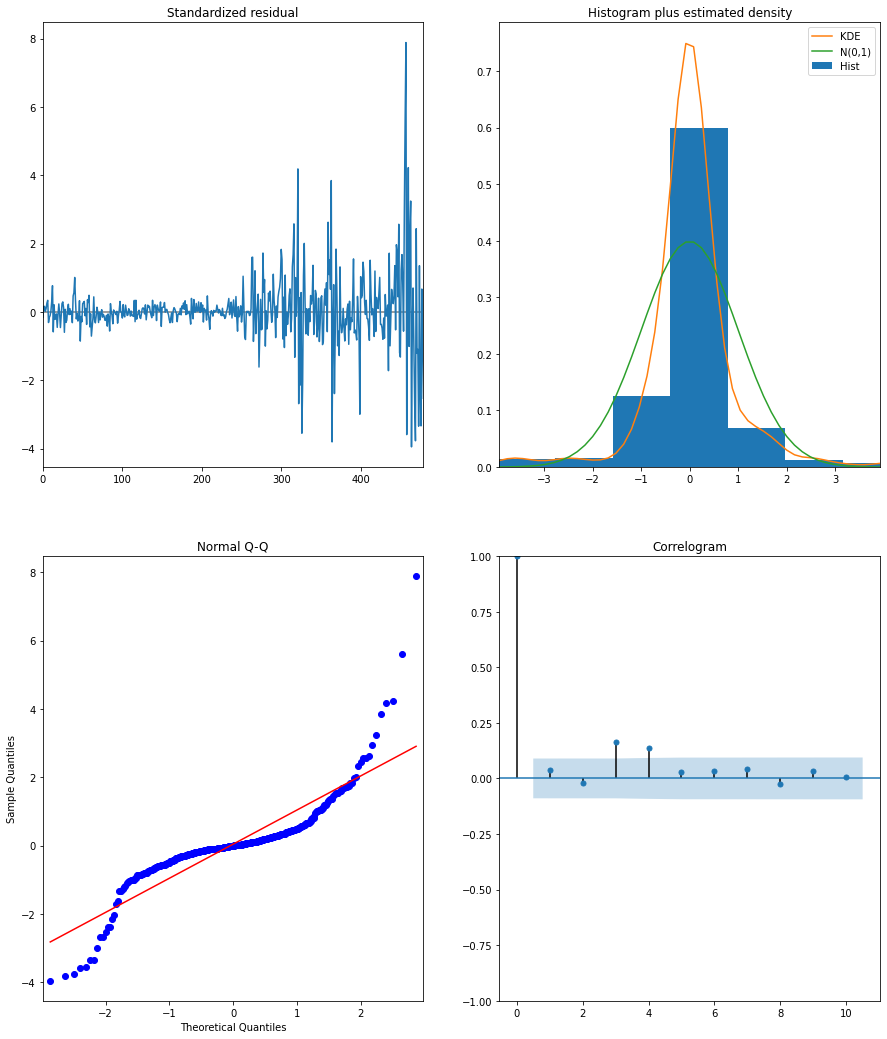

In [19]:
current_zip = 'Adj Close'
zip_params = output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(df_data[current_zip],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [20]:
def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y.plot(label='Observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.legend()

  return ax

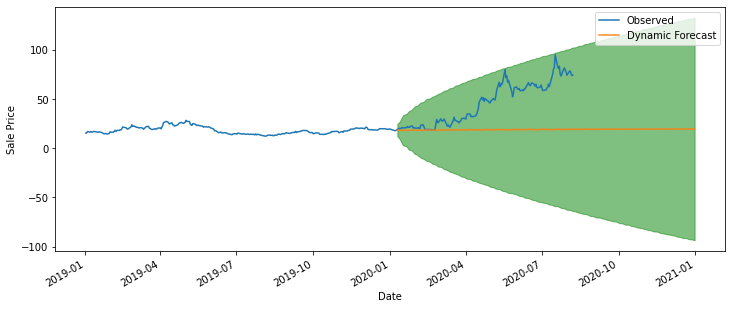

In [21]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train[current_zip])
prediction_visual

In [22]:
# Get the real and predicted values
forecast_11238 = pred_dynamic.predicted_mean
truth_11238 = train[current_zip]#['1996':]

# Compute the mean square error
mse = ((forecast_11238 - truth_11238) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast_11238 - truth_11238) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 1207.53
The Root Mean Squared Error of our forecasts is 34.75
